In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import numpy as np
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/data128.zip"

In [ ]:
train_path="/content/train_data128/train/"
val_path="/content/train_data128/val/"

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = '/content/data128/'
output_folder = '/content/train_data128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) 

Copying files: 6128 files [00:01, 3153.22 files/s]


In [ ]:
data_path = train_path
img_path = data_path+'image/'
mask_path = data_path+'tumorMask/'
img_files = os.listdir(img_path)
mask_files = os.listdir(mask_path)
img_files.sort()
mask_files.sort()
train_imgs = np.empty((len(img_files),128,128,4))
train_masks = np.empty((len(mask_files),128,128,4))
# count=0
for i in range(len(img_files)):
    img = cv2.imread(os.path.join(img_path, img_files[i]), cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(os.path.join(mask_path, mask_files[i]), cv2.IMREAD_UNCHANGED)
    # print(img_files[i])
    
    train_imgs[i] = img
    train_imgs[i] = mask
    # count+=1
    # print(count)
imgs = train_imgs.astype('float32') / 255.
masks = train_masks.astype('float32') / 255.


In [ ]:
data_path = val_path
img_path = data_path+'image/'
mask_path = data_path+'tumorMask/'
img_files = os.listdir(img_path)
mask_files = os.listdir(mask_path)
img_files.sort()
mask_files.sort()
val_imgs = np.empty((len(img_files),128,128,4))
val_masks = np.empty((len(mask_files),128,128,4))

for i in range(len(img_files)):
    img = cv2.imread(os.path.join(img_path, img_files[i]), cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(os.path.join(mask_path, mask_files[i]), cv2.IMREAD_UNCHANGED)
#     print(img_files[i])
    val_imgs[i] = img
    val_imgs[i] = mask
imgs = val_imgs.astype('float32') / 255.
masks = val_masks.astype('float32') / 255.


In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes=128,128,4,4

def model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    c1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    
    c6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(p4)
    cc1 = concatenate([c6, c4])
    cc1=Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(cc1)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    c7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    cc2 = concatenate([cc1,c7, c3])
    cc2=Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(cc2)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    c8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    cc3 = concatenate([cc2,c8, c2])
    cc3=Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(cc3)
#     cc3 = concatenate([cc3,cc2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    c9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    cc4 = concatenate([cc3,c9, c1])
#     cc4=Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(cc4)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(cc4)
    
    model=Model(inputs=[inputs],outputs=[outputs])
    
    
    
    return model
    
    

In [ ]:
model=model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes)

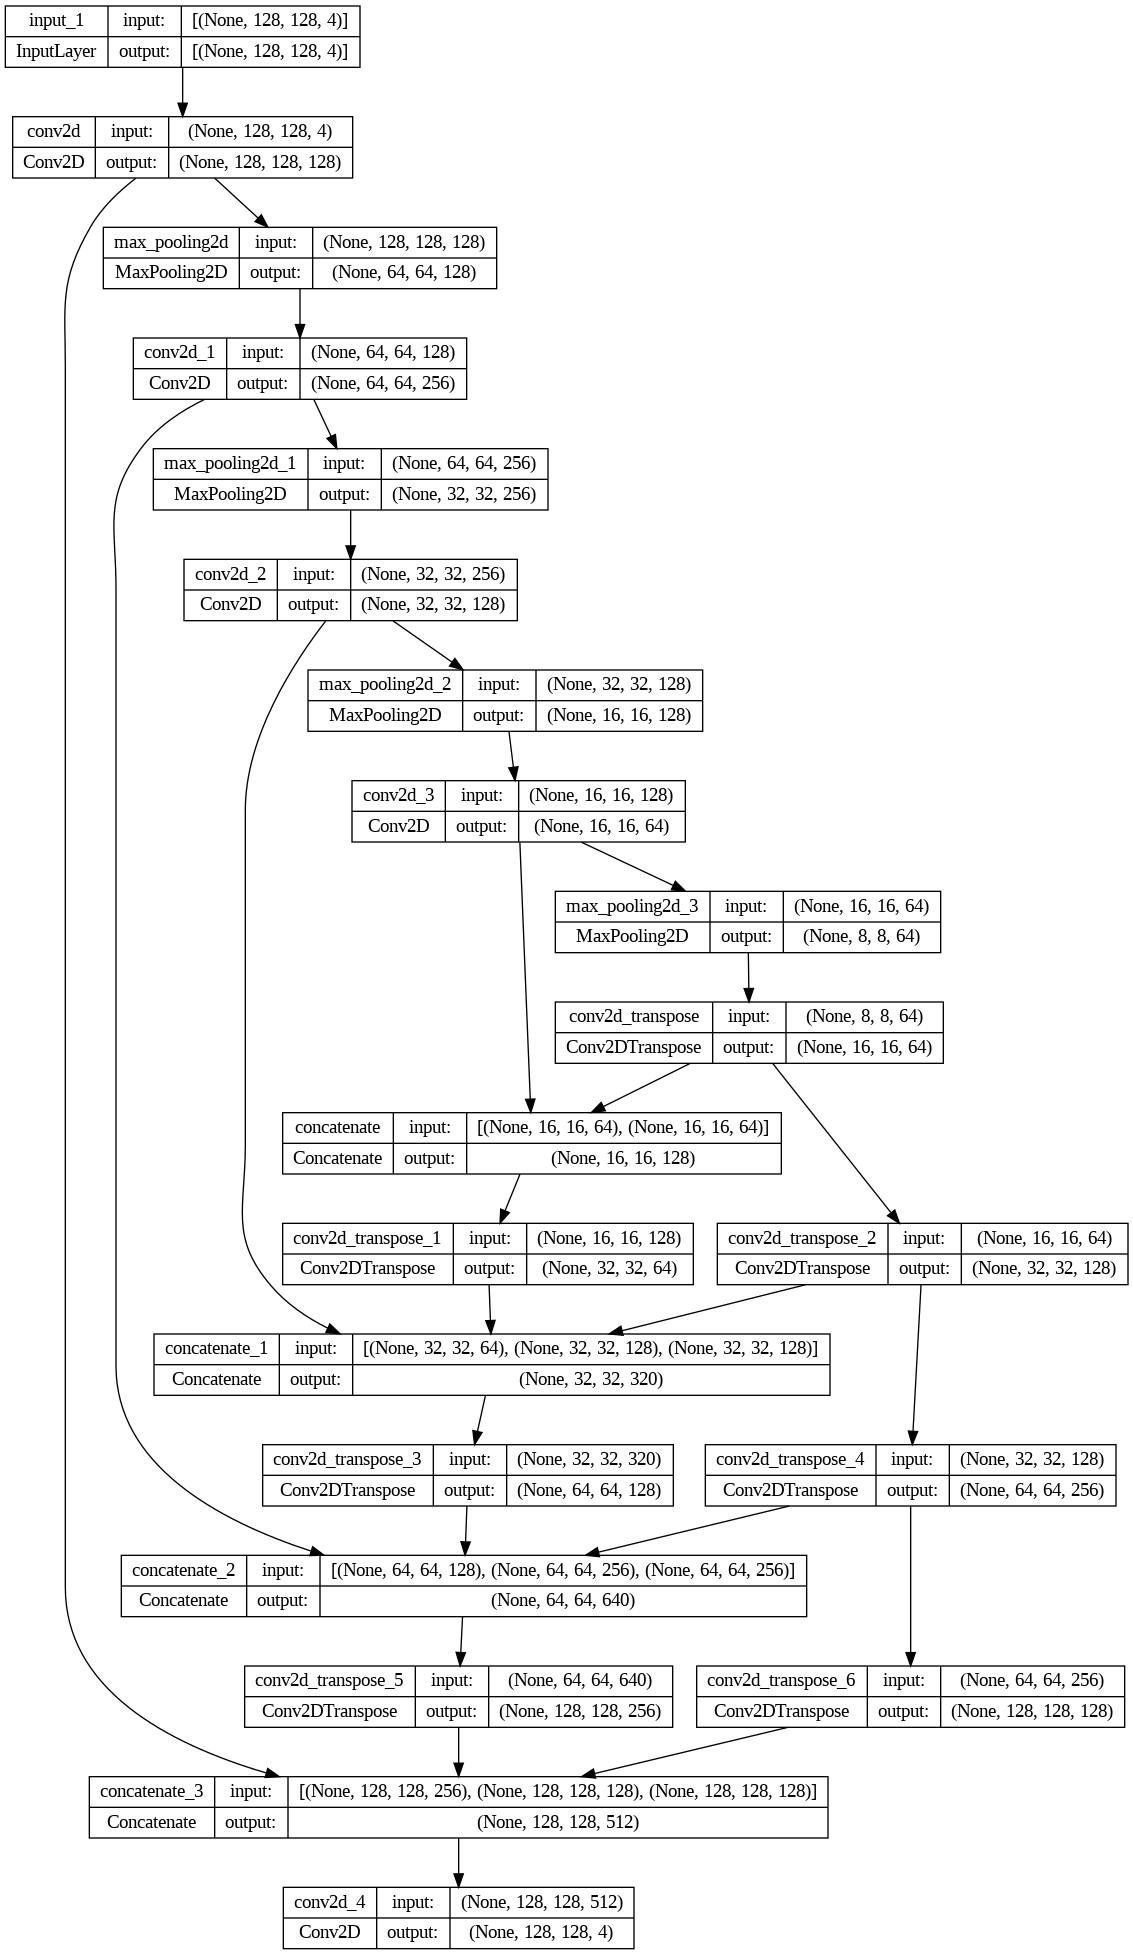

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# model.summary()

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'Dice Score'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred , tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = tf.divide(nominator, denominator)
        return result

In [ ]:
lossfn=DiceLoss()

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=[lossfn,'accuracy'])

In [ ]:
callback = [
    tf.keras.callbacks.ModelCheckpoint("figshare_segmentation_mseLoss.h5", save_best_only=True)
]

In [ ]:
history=model.fit(train_imgs,train_masks,validation_data=(val_imgs,val_masks),epochs=20,batch_size=16,callbacks=[callback])

Epoch 1/20
144/144 [==============================] - 48s 224ms/step - loss: 0.0086 - Dice Score: 0.8449 - accuracy: 0.9934 - val_loss: 0.0000e+00 - val_Dice Score: 1.0000 - val_accuracy: 1.0000
Epoch 2/20
144/144 [==============================] - 30s 206ms/step - loss: 0.0000e+00 - Dice Score: 1.0000 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_Dice Score: 1.0000 - val_accuracy: 1.0000
Epoch 3/20
144/144 [==============================] - 30s 211ms/step - loss: 0.0000e+00 - Dice Score: 1.0000 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_Dice Score: 1.0000 - val_accuracy: 1.0000
Epoch 4/20
144/144 [==============================] - 31s 216ms/step - loss: 0.0000e+00 - Dice Score: 1.0000 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_Dice Score: 1.0000 - val_accuracy: 1.0000
Epoch 5/20
144/144 [==============================] - 31s 213ms/step - loss: 0.0000e+00 - Dice Score: 1.0000 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_Dice Score: 1.0000 - val_accuracy: 1.0000
Epoch 6/2

In [ ]:
# ,validation_data=(val_imgs,val_masks)


In [ ]:
model.save(filepath="/content/model.h5")

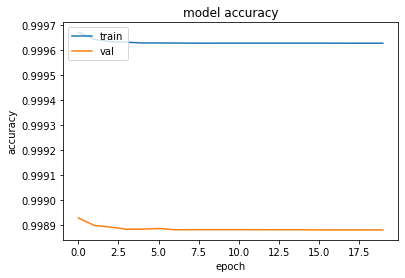

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


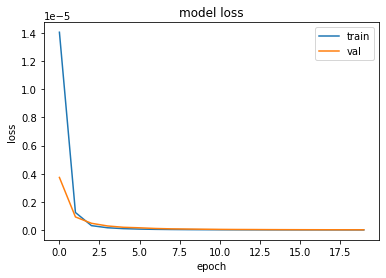

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()